Experimenting With And Implementing Convolution Filters
==========

- In this Jupyter notebook, I will experiment with and implement:

  - a mean filter using a "for" loop.
  - a convolution function that takes a raw image and a filter matrix as input, and outputs a convolved image.
  - mean filter using a filter matrix.
  - a Gaussian filter.
  - a Delta (Gradient) filter.
  - a Laplacian filter.
  - Fourier transform.
  - low and high pass filters.
- After using implementing low and high pass filters, I'll create a hybrid image using high-pass and low-pass fitlered images.

Load the image
-----

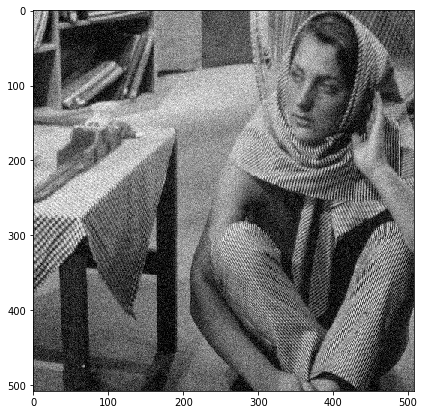

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from scipy.signal import convolve2d
from math import *
import time
%matplotlib inline

plt.rcParams['figure.figsize'] = [7, 7]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

# load the image
im = load_image('noisy_image.jpg')
im = im.mean(axis=2) # convert to grayscale
show_image(im)

Mean filter using a "for" loop
-----------

For every pixel in the image, we take the average of the neighboring pixels.

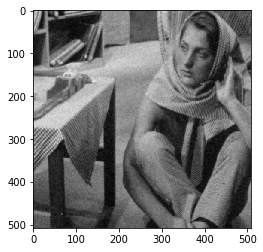

In [ ]:
im_pad = np.pad(im, 5, mode='constant')  # pad the border of the original image
im_out = np.zeros_like(im)  # initialize the output image array

neighbors = [[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]]
for i in range(len(im)):
  for j in range(len(im[0])):
    total = im[i][j]
    for n in neighbors:
      # check if in borders
      if (i+n[0] >= 0 and j+n[1] >= 0 and i+n[0] < len(im) and j+n[1] < len(im[0])):
        total += im[i+n[0]][j+n[1]]
    avg = total/9
    im_out[i][j] = avg

show_image(im_out)

Implement a convolution function
-----------

This is a convolution function that takes as input the raw image and a filter matrix, and outputs the convolved image.

In [ ]:
def convolve_image(image, filter_matrix):
    ''' Convolve a 2D image using the filter matrix.
    Args:
        image: a 2D numpy array.
        filter_matrix: a 2D numpy array.
    Returns:
        the convolved image, which is a 2D numpy array same size as the input image.
    '''
    # flip the filter_matrix for convolution
    filter_matrix = np.flipud(np.fliplr(filter_matrix))
    # initialize the output image array
    con_im = np.zeros_like(image)
    filter_row = len(filter_matrix)
    filter_col = len(filter_matrix[0])
    half_row = filter_row//2
    half_col = filter_col//2

    for i in range(len(im_pad)):
      for j in range(len(im_pad[0])):
        # check if in borders
        if (i-half_row >= 0 and j-half_col >= 0 and 
            i+half_row < len(im) and j+half_col < len(im[0])):
          # since we flipped our filter_matrix, and [j][i] is the "center"
          con_im[j][i] = (filter_matrix * im[j-half_col:j+half_col+1, 
                                             i-half_row:i+half_row+1]).sum()
    
    return con_im

Mean filter using a filter matrix.
----------------------------

Use the convolution function and filter matrix to show the convolution result, then compare the result with the `scipy.signal.convolve2d`function

In [ ]:
kernel = [[1/9 for i in range(3)] for j in range(3)]
mean_filt = np.array(kernel)

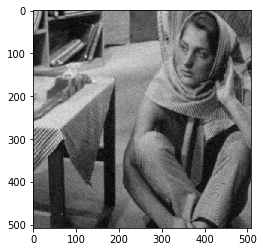

In [ ]:
show_image(convolve_image(im, mean_filt))

I compare my convolution result with the `scipy.signal.convolve2d` function

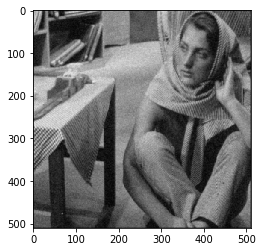

In [ ]:
show_image(convolve2d(im, mean_filt))

Gaussian Filter
---------------

I create a 2D Gaussian filter, and plot the result of the convolution.

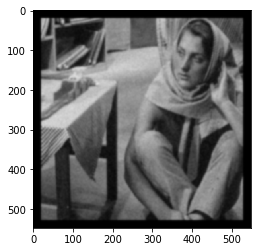

In [ ]:
def gaussian_filter(sigma, k=20):
    ''' 
    Args:
        sigma: the standard deviation of Gaussian kernel.
        k: controls size of the filter matrix. 
    Returns:
        a 2D Gaussian filter matrix of the size (2k+1, 2k+1).
    '''
    gauss_size = 2 * k + 1
    g_filter = np.zeros((gauss_size, gauss_size))
    half_row = half_col = gauss_size//2

    for i in range(-half_row, half_row+1):
      for j in range(-half_col, half_col+1):
        g_filter[i+half_row][j+half_col] = (1/(2*np.pi*(sigma**2)) * 
                                            np.exp(-(i**2 + j**2)/(2*sigma**2)))
    return g_filter

show_image(convolve2d(im, gaussian_filter(2)))

I change the sigma parameter to change the amount the image is blurred

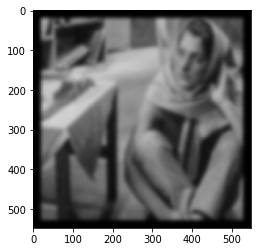

In [ ]:
show_image(convolve2d(im, gaussian_filter(5)))

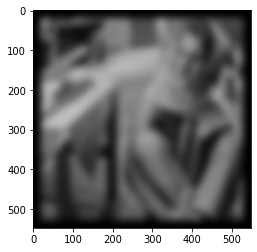

In [ ]:
show_image(convolve2d(im, gaussian_filter(10)))

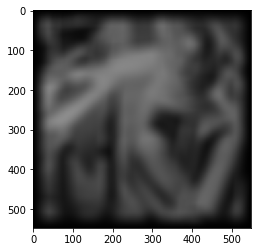

In [ ]:
show_image(convolve2d(im, gaussian_filter(15)))

Visualizing Gaussian Filter
---------------------------
I change the sigma parameter below to visualize the Gaussian filter directly.

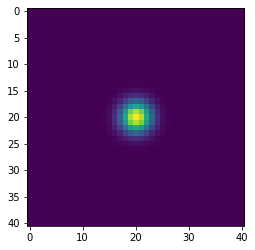

In [ ]:
plt.imshow(gaussian_filter(sigma=2))

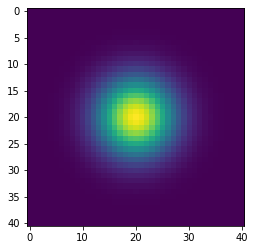

In [ ]:
plt.imshow(gaussian_filter(sigma=5))

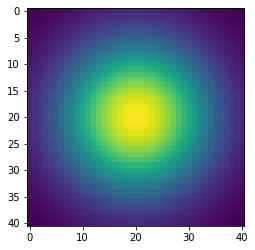

In [ ]:
plt.imshow(gaussian_filter(sigma=10))

Using convolutions to find edges in images.
=========================

Edge detection is useful for finding the boundaries regions in an image. I will use convolutions to find edges in images.

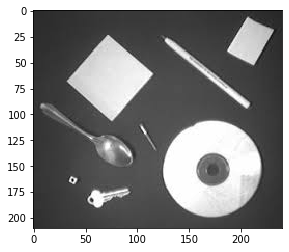

In [ ]:
im = load_image('edge_detection_image.jpg')
im = im.mean(axis=2) # convert to grayscale
show_image(im)

Delta/Gradient Filters
-------------

The simplest edge detector is a Delta/Gradient filter. I implement a Delta/Gradient filter below, and convolve it with the image.

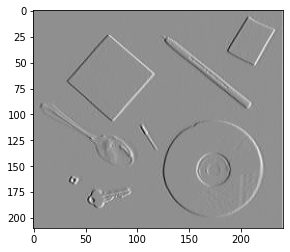

In [ ]:
# x-direction horizontal 1D gradient filter
kernel = [[-1, 1]]
delta_filt = np.array(kernel)

plt.imshow(convolve2d(im, delta_filt), cmap='gray')

Noise
-----

An issue with the delta filter is that it is sensitive to noise in the image. I can add some Gaussian noise to the image below and observe that the edges are harder to see.

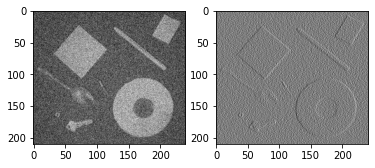

In [ ]:
im = load_image('edge_detection_image.jpg')
im = im.mean(axis=2)
im = im + 0.2*np.random.randn(*im.shape)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im, cmap='gray')
axarr[1].imshow(convolve2d(im, delta_filt), cmap='gray')

Laplacian Filters
-----------------

Laplacian filters are edge detectors that are robust to noise. I implement a Laplacian filter below for both horizontal and vertical edges.

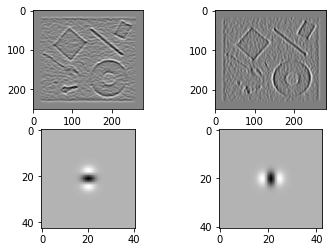

In [ ]:
first_degree_x = convolve2d(gaussian_filter(2), delta_filt)
first_degree_y = convolve2d(gaussian_filter(2), delta_filt.transpose())
lap_x_filt = convolve2d(first_degree_x, delta_filt)
lap_y_filt = convolve2d(first_degree_y, delta_filt.transpose())

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(convolve2d(im, lap_y_filt), cmap='gray')
axarr[0,1].imshow(convolve2d(im, lap_x_filt), cmap='gray')
axarr[1,0].imshow(lap_y_filt, cmap='gray')
axarr[1,1].imshow(lap_x_filt, cmap='gray')

Hybrid Images
========================

Hybrid images is a technique to combine two images in one. Depending on the distance you view the image, you will see a different image. This is done by merging the high-frequency components of one image with the low-frequency components of a second image. I will use the Fourier transform to make these images.

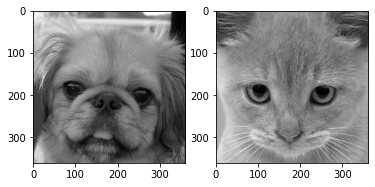

In [ ]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2

dog = load_image('dog.jpg').mean(axis=-1)[:, 25:-24]
cat = load_image('cat.jpg').mean(axis=-1)[:, 25:-24]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(dog, cmap='gray')
axarr[1].imshow(cat, cmap='gray')

Fourier Transform
-----------------

I compute the Fourier transform of the two images using the `fft2` and `fftshift` function.

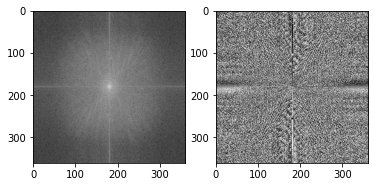

In [ ]:
cat_fft = fftshift(fft2(cat))
dog_fft = fftshift(fft2(dog))

# Visualize the magnitude and phase of cat_fft. This is a complex number, so we visualize
# the magnitude and angle of the complex number.
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.log(np.abs(cat_fft)), cmap='gray')
axarr[1].imshow(np.angle(cat_fft), cmap='gray')

Low and High Pass Filters
-------------------------

By masking the Fourier transform, I can compute both low and high pass of the images. In Fourier space, I create a mask for a high pass filter of the cat, and a mask for a low pass filter of the dog. Then, I convert them back to image space and visualize these images.

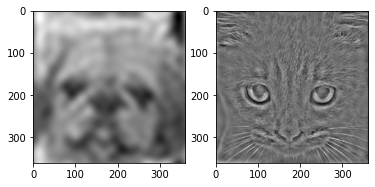

In [ ]:
high_pass = np.pad(np.zeros((21, 21)), 170, 'constant', constant_values=1.0)
low_pass = np.pad(np.ones((21, 21)), 170)

cat_filtered = ifft2(ifftshift(cat_fft * high_pass))
dog_filtered = ifft2(ifftshift(dog_fft * low_pass))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(dog_filtered.real, cmap='gray')
axarr[1].imshow(cat_filtered.real, cmap='gray')

Hybrid Image Results
--------------------

Now that I have the high pass and low pass fitlered images, I can create a hybrid image by adding them. I combine the images below.

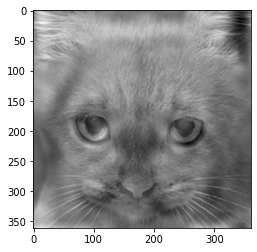

In [ ]:
hybrid = cat_filtered.real + dog_filtered.real

plt.imshow(hybrid, cmap='gray')

Acknowledgements
----------------

This project is based off assignments from Aude Oliva at MIT, and James Hays at Georgia Tech. 